In [65]:
import sys


assert sys.version_info >= (3, 10)

# Chapter 3: Classification

**What's different from Chapter 2?** Chapter 2 was **regression** (predicting continuous values like house prices). This chapter covers **classification** - predicting discrete categories (like "is this a 5?" or "which digit is this?").

## Setup

These cells verify you have the correct Python and scikit-learn versions.

In [66]:
from packaging.version import Version
import sklearn

assert Version(sklearn.__version__) >= Version("1.6.1")

In [67]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [68]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

## MNIST Dataset

**Why MNIST?** It's the "Hello World" of machine learning classification:
- 70,000 images of handwritten digits (0-9)
- Each image is 28x28 pixels = 784 features
- Well-studied benchmark - you can compare your results to others
- Simple enough to train quickly, complex enough to be interesting

In [69]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [70]:
X, y = mnist.data, mnist.target
X


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(70000, 784))

**Understanding the data structure:**
- `X` = features (pixel values). Shape: (70000, 784) - 70k images, each flattened to 784 pixels
- `y` = labels (the actual digit). Shape: (70000,) - one label per image

Each pixel value ranges from 0 (white) to 255 (black).

In [71]:
X.shape


(70000, 784)

In [72]:
y

array(['5', '0', '4', ..., '4', '5', '6'], shape=(70000,), dtype=object)

In [73]:
y.shape

(70000,)

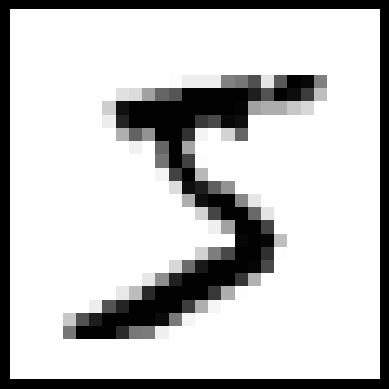

In [74]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)

plt.show()

**Visualizing a digit:** The data is stored as a flat array of 784 values. To see it as an image, we reshape it back to 28x28 pixels. This is the first digit in the dataset - a handwritten "5".

In [75]:
y[0]

'5'

In [76]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Train/Test Split

**Why this specific split?** MNIST is pre-shuffled and conventionally split:
- First 60,000 images = training set
- Last 10,000 images = test set

This is a standard split so you can compare your results with published benchmarks.

In [77]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

## Binary Classification: "5-Detector"

**Why start with binary?** Before tackling 10-class classification, let's build a simpler model: "Is this digit a 5, or not?"

- `y_train_5` = True if the digit is '5', False otherwise
- This converts a 10-class problem into a simple yes/no problem

Binary classifiers are easier to understand and introduce key concepts.

In [78]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

,"loss loss: {'hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'}, default='hinge'The loss function to be used.- 'hinge' gives a linear SVM.- 'log_loss' gives logistic regression, a probabilistic classifier.- 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates.- 'squared_hinge' is like hinge but is quadratically penalized.- 'perceptron' is the linear loss used by the perceptron algorithm.- The other losses, 'squared_error', 'huber', 'epsilon_insensitive' and 'squared_epsilon_insensitive' are designed for regression but can be useful in classification as well; see :class:`~sklearn.linear_model.SGDRegressor` for a description.More details about the losses formulas can be found in the :ref:`User Guide` and you can find a visualisation of the lossfunctions in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_loss_functions.py`.",'hinge'
,"penalty penalty: {'l2', 'l1', 'elasticnet', None}, default='l2'The penalty (aka regularization term) to be used. Defaults to 'l2'which is the standard regularizer for linear SVM models. 'l1' and'elasticnet' might bring sparsity to the model (feature selection)not achievable with 'l2'. No penalty is added when set to `None`.You can see a visualisation of the penalties in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_penalties.py`.",'l2'
,"alpha alpha: float, default=0.0001Constant that multiplies the regularization term. The higher thevalue, the stronger the regularization. Also used to compute thelearning rate when `learning_rate` is set to 'optimal'.Values must be in the range `[0.0, inf)`.",0.0001
,"l1_ratio l1_ratio: float, default=0.15The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1.l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.Only used if `penalty` is 'elasticnet'.Values must be in the range `[0.0, 1.0]` or can be `None` if`penalty` is not `elasticnet`... versionchanged:: 1.7 `l1_ratio` can be `None` when `penalty` is not ""elasticnet"".",0.15
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If False, thedata is assumed to be already centered.",True
,"max_iter max_iter: int, default=1000The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the ``fit`` method, and not the:meth:`partial_fit` method.Values must be in the range `[1, inf)`... versionadded:: 0.19",1000
,"tol tol: float or None, default=1e-3The stopping criterion. If it is not None, training will stopwhen (loss > best_loss - tol) for ``n_iter_no_change`` consecutiveepochs.Convergence is checked against the training loss or thevalidation loss depending on the `early_stopping` parameter.Values must be in the range `[0.0, inf)`... versionadded:: 0.19",0.001
,"shuffle shuffle: bool, default=TrueWhether or not the training data should be shuffled after each epoch.",True
,"verbose verbose: int, default=0The verbosity level.Values must be in the range `[0, inf)`.",0
,"epsilon epsilon: float, default=0.1Epsilon in the epsilon-insensitive loss functions; only if `loss` is'huber', 'epsilon_insensitive', or 'squared_epsilon_insensitive'.For 'huber', determines the threshold at which it becomes lessimportant to get the prediction exactly right.For epsilon-insensitive, any differences between the current predictionand the correct label are ignored if they are less than this threshold.Values must be in the range `[0.0, inf)`.",0.1
,"n_jobs n_jobs: int, default=NoneThe number of CPUs to use to do the OVA (One Versus All, formulti-class problems) computation.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


**SGDClassifier (Stochastic Gradient Descent):**
- Efficient for large datasets - processes one sample at a time
- Works well with high-dimensional data like images
- Can be trained incrementally (online learning)
- Under the hood, it's training a linear model using gradient descent

In [79]:
sgd_clf.predict([some_digit])

array([ True])

**Testing our classifier:** We feed it the first digit (which we know is a '5'). It correctly predicts `True` - it IS a 5!

In [80]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

## Measuring Performance with Cross-Validation

**95-96% accuracy - sounds great, right?** Let's verify with 3-fold cross-validation.

In [81]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)  # add shuffle=True if the dataset is
                                       # not already shuffled
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


**Manual cross-validation (for understanding):** This shows what `cross_val_score` does internally:
1. Split data into K folds (stratified to maintain class proportions)
2. Train on K-1 folds, test on the remaining fold
3. Repeat K times, rotating which fold is held out

In [82]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


**Wait - is 95% accuracy actually good?** Let's check with a "dumb" baseline.

`DummyClassifier` predicts the most frequent class (not-5) for everything. It never predicts "5".

In [83]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

**91% accuracy by doing NOTHING!** 

This reveals a critical lesson: **accuracy is misleading for imbalanced datasets**. Only ~10% of digits are 5s, so predicting "not 5" for everything gets 90% accuracy!

We need better metrics: precision, recall, F1-score, confusion matrix.

In [84]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

## Confusion Matrix

**Why `cross_val_predict` instead of `cross_val_score`?** 
- `cross_val_score` returns scores
- `cross_val_predict` returns actual predictions for each sample

This gives us predictions made when each sample was in the test fold - "clean" predictions the model never trained on.

In [85]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

**Reading the Confusion Matrix:**
```
                  Predicted
                  Not-5    5
Actual  Not-5    [53892,  687]   → True Negatives, False Positives
        5        [ 1891, 3530]   → False Negatives, True Positives
```

- **True Negatives (53892)**: Correctly predicted "not 5"
- **False Positives (687)**: Said "5" but was wrong (Type I error)
- **False Negatives (1891)**: Missed a real 5 (Type II error)
- **True Positives (3530)**: Correctly detected a 5

In [86]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

**Perfect classifier comparison:** A perfect model would have all predictions on the diagonal (no false positives or false negatives).

In [87]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

## Precision and Recall

**Precision** = "When I predict 5, how often am I right?"
- Formula: TP / (TP + FP) = 3530 / (3530 + 687) = **83.7%**
- High precision = few false alarms

In [88]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

**Recall** (Sensitivity) = "Of all actual 5s, how many did I catch?"
- Formula: TP / (TP + FN) = 3530 / (3530 + 1891) = **65.1%**
- High recall = few missed positives

**Trade-off:** Increasing one often decreases the other!

In [89]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

**F1 Score** = Harmonic mean of precision and recall
- Formula: 2 × (precision × recall) / (precision + recall)
- Balances both metrics into a single number
- Useful when you need a single metric to compare models
- Penalizes models with very unbalanced precision/recall

In [90]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

## The Precision/Recall Trade-off

**How does SGDClassifier decide?** It computes a "decision score" for each sample. If score > threshold (default 0), predict positive.

`decision_function()` returns this raw score before thresholding.

In [91]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

**Adjusting the threshold:**
- **Lower threshold** → More positives → Higher recall, lower precision
- **Higher threshold** → Fewer positives → Higher precision, lower recall

You can tune this based on your needs!

In [92]:
y_some_digit_pred

array([ True])

In [93]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

**Example:** With threshold=3000, the same digit is now predicted as "not 5" because its score (2164) is below the threshold. Higher threshold = more conservative predictions.

In [94]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [95]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

**Precision-Recall Curve:** `precision_recall_curve` computes precision and recall for ALL possible thresholds. This shows you the entire trade-off landscape.

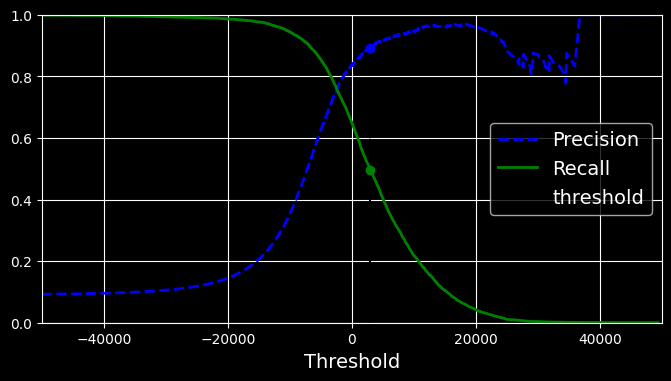

In [96]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

**Precision vs Recall vs Threshold:** Notice how precision and recall move in opposite directions as threshold changes. Pick a threshold based on your application:
- **Spam filter**: High precision (don't delete good emails)
- **Cancer screening**: High recall (don't miss any cancer)

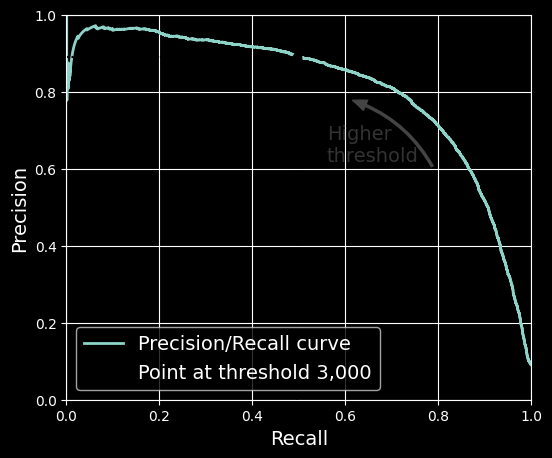

In [97]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

In [98]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991439557)

**Finding threshold for 90% precision:** If we need at least 90% precision, we find the lowest threshold that achieves it.

In [99]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [100]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [101]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

**The cost of 90% precision:** Recall drops to ~48%! We catch fewer 5s but are more confident when we do. This is the precision-recall trade-off in action.

In [102]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

## ROC Curve (Receiver Operating Characteristic)

**Another way to visualize the trade-off:** ROC plots True Positive Rate (recall) vs False Positive Rate at various thresholds.

- **TPR (True Positive Rate)** = Recall = TP / (TP + FN)
- **FPR (False Positive Rate)** = FP / (FP + TN)

A perfect classifier hugs the top-left corner. A random classifier follows the diagonal.

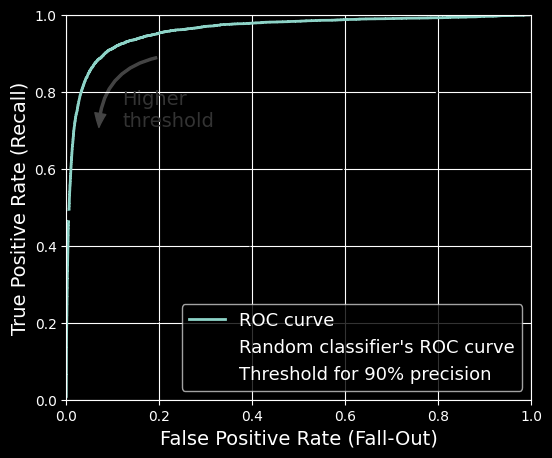

In [103]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

In [104]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**AUC (Area Under the Curve):** Summarizes the entire ROC curve as a single number.
- **AUC = 1.0**: Perfect classifier
- **AUC = 0.5**: Random classifier (no better than coin flip)
- **AUC = 0.96**: Our SGD classifier is quite good!

Use AUC when you want to compare classifiers without choosing a specific threshold.

In [105]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

## Comparing Classifiers: Random Forest

**Why try Random Forest?** Different classifiers have different strengths. Random Forest often works well "out of the box" - let's compare it to SGD.

In [106]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

**Note:** Random Forest uses `predict_proba` instead of `decision_function`. It returns probability estimates for each class [P(not-5), P(5)].

In [107]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [108]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

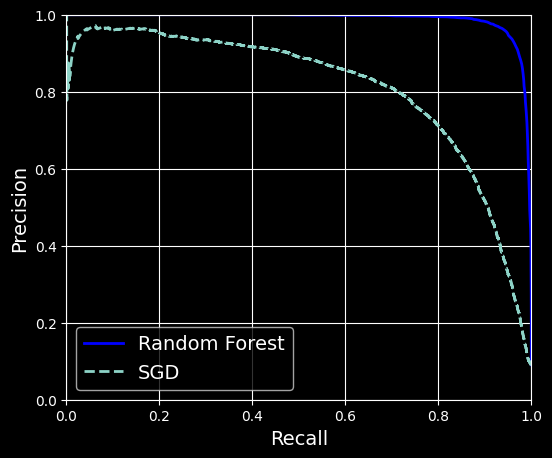

In [109]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

In [110]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

**Random Forest Results:**
- F1 = 0.93 (vs 0.73 for SGD) - Much better!
- Precision = 99% 
- Recall = 87%
- AUC = 0.998 (near perfect!)

Random Forest dominates SGD on this task. But it's slower to train.

In [111]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [112]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [113]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

In [114]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


## Multiclass Classification

**Beyond binary:** Now let's classify ALL digits (0-9), not just detect 5s.

**SVM (Support Vector Machine):** A powerful classifier. Note: we train on only 2000 samples here because SVM is slow on large datasets.

In [115]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [116]:
some_digit_scores= svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 3.79297828,  0.72949369,  6.06184129,  8.29800527, -0.29383983,
         9.30157597,  1.74723215,  2.77365456,  7.20601456,  4.82245092]])

**How does multiclass work internally?** SVM outputs a score for EACH class. The class with the highest score wins.

Here, class 5 has the highest score (9.30), so it predicts "5". Notice it's quite confident - the next highest is class 3 with 8.30.

In [117]:
class_id = some_digit_scores.argmax()
class_id

np.int64(5)

In [118]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

,"estimator estimator: estimator objectA regressor or a classifier that implements :term:`fit`.When a classifier is passed, :term:`decision_function` will be usedin priority and it will fallback to :term:`predict_proba` if it is notavailable.When a regressor is passed, :term:`predict` is used.",SVC(random_state=42)
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation: the `n_classes`one-vs-rest problems are computed in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: 0.20 `n_jobs` default changed from 1 to None",None
,"verbose verbose: int, default=0The verbosity level, if non zero, progress messages are printed.Below 50, the output is sent to stderr. Otherwise, the output is sentto stdout. The frequency of the messages increases with the verbositylevel, reporting all iterations at 10. See :class:`joblib.Parallel` formore details... versionadded:: 1.1",0
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001


## One-vs-Rest (OvR) Strategy

**How to use binary classifiers for multiclass?**

**OvR (One-vs-Rest):** Train 10 binary classifiers:
- Classifier 0: "Is it a 0?" vs "not 0"
- Classifier 1: "Is it a 1?" vs "not 1"
- ... and so on

To predict, run all 10 classifiers and pick the one with highest confidence.

In [119]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [120]:
len(ovr_clf.estimators_)

10

In [121]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

**SGD for Multiclass:** SGDClassifier automatically uses OvR when given multiclass targets. It trains one binary classifier per class behind the scenes.

**Note:** It predicts "3" for our digit - wrong! SGD isn't perfect, especially without tuning.

In [122]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -19047.55566534,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [123]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87745, 0.85835, 0.8698 ])

**Multiclass accuracy:** ~87% - decent but not great. For 10 classes, random guessing would give 10%, so 87% is meaningful. Can we do better?

In [124]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(svm_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.9596, 0.9602, 0.961 ])

## Feature Scaling Helps!

**Remember from Chapter 2:** Many algorithms (especially SVMs and gradient-based methods) work better with scaled features.

`StandardScaler` transforms pixel values to have mean=0 and std=1. This often improves performance significantly!

In [129]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
plt.rc('font', size=9)  # extra code – make the text smaller
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

C:\Users\Ah\miniconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
sample_weight = (y_train_pred != y_train)
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()

In [ ]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [ ]:
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")

plt.show()

In [131]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1 )
y_multiple = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multiple)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [132]:
knn_clf.predict([some_digit])

array([[False,  True]])